In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/Deep_Learning_Project

/content/drive/MyDrive/Deep_Learning_Project


In [40]:
import numpy as np
import pandas as pd
import h5py
import pickle
import tensorflow as tf
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [41]:
import re
def token(sentence, remove_vowels=False, remove_repeat=False, minchars=2):
    tokens = []
#   for t in re.findall("[A-Z]{2,}(?![a-z])|[A-Z][a-z]+(?=[A-Z])|[\w]+",sentence.lower()):
    for t in re.findall("[a-zA-Z]+",sentence.lower()):

        if len(t)>=minchars:
            if remove_vowels:
                t=removeVovels(t)
            if remove_repeat:
                t=removeRepeat(t)
            tokens.append(t)
    return tokens

VOWELS = ['a', 'e', 'i', 'o', 'u']

def removeRepeat(string):
    return re.sub(r'(.)\1+', r'\1\1', string)     

def removeVovels(string):
    return ''.join([l for l in string.lower() if l not in VOWELS])

# if __name__ == '__main__':
#     pass

def normalize_matrix(matrix):
    pass

In [42]:
SEPERATOR = '\t'
DATA_COLUMN = 1
LABEL_COLUMN = 3
LABELS = ['0','1','2'] # 0 -> Negative, 1-> Neutral, 2-> Positive
mapping_char2num = {}
mapping_num2char = {}
MAXLEN = 200

#LSTM Model Parameters
#Embedding
MAX_FEATURES = 0
embedding_size = 128
# Convolution
filter_length = 3
nb_filter = 128
pool_length = 3
# LSTM
lstm_output_size = 128
# Training
batch_size = 128
number_of_epochs = 50
numclasses = 3
test_size = 0.2

In [55]:
lines = pd.read_csv('Comments.csv')
lines.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7', 'Unnamed: 8'], axis=1, inplace=True)
lines

,Comments,Unnamed: 1
0,Jitne bhi desh me hamle huye sab jehadi mullo ...,0
1,Aap khud mante hai ki apse ache nomination the...,1
2,Sir aap bahut he achi treh se story ko discrib...,0
3,wo cleaning hi kar rhey they,0
4,"gazi baba fudu planner hai , usko nikal do nau...",1
...,...,...
13114,CBD oil is not a drug...it is used as medicine...,1
13115,They are trying to defame Sushant Singh Rajput.,1
13116,Pura Bollywood isilie chup tha q ki pura indus...,0
13117,Good morning Sir ji,0


In [47]:
def parse(seperator,datacol,labelcol,labels):
    """
    Purpose -> Data I/O
    Input   -> Data file containing sentences and labels along with the global variables
    Output  -> Sentences cleaned up in list of lists format along with the labels as a numpy array
    """
    #Reads the files and splits data into individual lines
    # f=open('Codemixed.txt','r', encoding='utf-8')
    # lines = f.read()
    # lines = lines.lower().split('\n')[:-1]

    lines = pd.read_csv('Comments.csv')

    X_train = []
    Y_train = []
    
    #Processes individual lines
    for line in lines:
        # Seperator for the current dataset. Currently '\t'. 
        line = line.split(seperator)
        #Token is the function which implements basic preprocessing as mentioned in our paper
        tokenized_lines = token(line[datacol])
    
        #Creates character lists
        char_list = []
        for words in tokenized_lines:
            for char in words:
                char_list.append(char)
            char_list.append(' ')
        #print(char_list) - Debugs the character list created
        X_train.append(char_list)
    
        #Appends labels
        if line[labelcol] == labels[0]:
            Y_train.append(0)
        if line[labelcol] == labels[1]:
            Y_train.append(1)
        if line[labelcol] == labels[2]:
            Y_train.append(2)
    
    #Converts Y_train to a numpy array	
    Y_train = np.asarray(Y_train)
    assert(len(X_train) == Y_train.shape[0])

    return [X_train,Y_train]

In [48]:
def convert_char2num(mapping_n2c,mapping_c2n,trainwords,maxlen):
    """
    Purpose -> Convert characters to integers, a unique value for every character
    Input   -> Training data (In list of lists format) along with global variables
    Output  -> Converted training data along with global variables
    """
    allchars = []
    errors = 0

    #Creates a list of all characters present in the dataset
    for line in trainwords:
        try:
            allchars = set(allchars+line)
            allchars = list(allchars)
        except:
            errors += 1

    #print(errors) #Debugging
    #print(allchars) #Debugging 

    #Creates character dictionaries for the characters
    charno = 0
    for char in allchars:
        mapping_char2num[char] = charno
        mapping_num2char[charno] = char
        charno += 1

    assert(len(allchars)==charno) #Checks

    #Converts the data from characters to numbers using dictionaries 
    X_train = []
    for line in trainwords:
        char_list=[]
        for letter in line:
            char_list.append(mapping_char2num[letter])
        #print(no) -- Debugs the number mappings
        X_train.append(char_list)
    print(mapping_char2num)
    print(mapping_num2char)
    #Pads the X_train to get a uniform vector
    #TODO: Automate the selection instead of manual input
    X_train = sequence.pad_sequences(X_train[:], maxlen=maxlen)
    return [X_train,mapping_num2char,mapping_char2num,charno]

In [49]:
def RNN(X_train,y_train,args):
    """
    Purpose -> Define and train the proposed LSTM network
    Input   -> Data, Labels and model hyperparameters
    Output  -> Trained LSTM network
    """
    #Sets the model hyperparameters
    #Embedding hyperparameters
    max_features = args[0]
    maxlen = args[1]
    embedding_size = args[2]
    # Convolution hyperparameters
    filter_length = args[3]
    nb_filter = args[4]
    pool_length = args[5]
    # LSTM hyperparameters
    lstm_output_size = args[6]
    # Training hyperparameters
    batch_size = args[7]
    nb_epoch = args[8]
    numclasses = args[9]
    test_size = args[10] 

    #Format conversion for y_train for compatibility with Keras
    y_train = np_utils.to_categorical(y_train, numclasses) 
    #Train & Validation data splitting
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, random_state=42)
    
    #Build the sequential model
    # Model Architecture is:
    # Input -> Embedding -> Conv1D+Maxpool1D -> LSTM -> LSTM -> FC-1 -> Softmaxloss
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    # model.add(Convolution1D(nb_filter=nb_filter,
    #filter_length=filter_length,
    #activation='relu',
    #subsample_length=1))
    # model.add(MaxPooling1D(pool_length=pool_length))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=True))
    model.add(LSTM(lstm_output_size, dropout_W=0.2, dropout_U=0.2, return_sequences=False))
    model.add(Dense(numclasses))
    model.add(Activation('softmax'))

    # Optimizer is Adamax along with categorical crossentropy loss
    model.compile(loss='categorical_crossentropy',
                optimizer='adamax',
                metrics=['accuracy'])


    print('Train...')
    #Trains model for 50 epochs with shuffling after every epoch for training data and validates on validation data
    model.fit(X_train, y_train, 
              batch_size=batch_size, 
              shuffle=True, 
              nb_epoch=nb_epoch,
              validation_data=(X_valid, y_valid))
    return model

In [50]:
if __name__ == '__main__':
    """
    Master function
    """
    print('Starting RNN Engine...\nModel: Char-level LSTM.\nParsing data files...')
    out = parse(SEPERATOR,DATA_COLUMN,LABEL_COLUMN,LABELS)
    X_train = out[0]
    y_train = out[1]
    print('Parsing complete!')

    print('Creating character dictionaries and format conversion in progess...')


Starting RNN Engine...
Model: Char-level LSTM.
Parsing data files...


IndexError: ignored

In [35]:
out

[array([[ 0,  0,  0, ..., 16,  0, 13],
        [ 0,  0,  0, ...,  0, 22, 13],
        [ 0,  0,  0, ..., 11, 21, 13],
        ...,
        [ 0,  0,  0, ...,  5,  0, 13],
        [ 0,  0,  0, ...,  0, 20, 13],
        [ 0,  0,  0, ..., 21, 21, 13]], dtype=int32),
 {0: 'i',
  1: 'k',
  2: 'm',
  3: 'q',
  4: 'v',
  5: 't',
  6: 'b',
  7: 'x',
  8: 's',
  9: 'n',
  10: 'f',
  11: 'a',
  12: 'l',
  13: ' ',
  14: 'w',
  15: 'z',
  16: 'j',
  17: 'y',
  18: 'p',
  19: 'u',
  20: 'e',
  21: 'r',
  22: 'o',
  23: 'h',
  24: 'd',
  25: 'g',
  26: 'c'},
 {' ': 13,
  'a': 11,
  'b': 6,
  'c': 26,
  'd': 24,
  'e': 20,
  'f': 10,
  'g': 25,
  'h': 23,
  'i': 0,
  'j': 16,
  'k': 1,
  'l': 12,
  'm': 2,
  'n': 9,
  'o': 22,
  'p': 18,
  'q': 3,
  'r': 21,
  's': 8,
  't': 5,
  'u': 19,
  'v': 4,
  'w': 14,
  'x': 7,
  'y': 17,
  'z': 15},
 27]

In [14]:
out = convert_char2num(mapping_num2char,mapping_char2num,X_train,MAXLEN)
mapping_num2char = out[1]
mapping_char2num = out[2]
MAX_FEATURES = out[3]
X_train = np.asarray(out[0])
y_train = np.asarray(y_train).flatten()
print('Complete!')

print('Splitting data into train and test...')
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)



{'i': 0, 'k': 1, 'm': 2, 'q': 3, 'v': 4, 't': 5, 'b': 6, 'x': 7, 's': 8, 'n': 9, 'f': 10, 'a': 11, 'l': 12, ' ': 13, 'w': 14, 'z': 15, 'j': 16, 'y': 17, 'p': 18, 'u': 19, 'e': 20, 'r': 21, 'o': 22, 'h': 23, 'd': 24, 'g': 25, 'c': 26}
{0: 'i', 1: 'k', 2: 'm', 3: 'q', 4: 'v', 5: 't', 6: 'b', 7: 'x', 8: 's', 9: 'n', 10: 'f', 11: 'a', 12: 'l', 13: ' ', 14: 'w', 15: 'z', 16: 'j', 17: 'y', 18: 'p', 19: 'u', 20: 'e', 21: 'r', 22: 'o', 23: 'h', 24: 'd', 25: 'g', 26: 'c'}
Complete!
Splitting data into train and test...
X_train shape: (3103, 200)
X_test shape: (776, 200)


In [15]:
y_train = np_utils.to_categorical(y_train ,numclasses) 

In [16]:

#Train & Validation data splitting
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size)

In [17]:
# # define model
# model = Sequential()
# model.add(Embedding(embedding_dim, 100, input_length=max_length))
# model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(3, activation='sigmoid'))

In [18]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [19]:
model = Sequential()
model.add(Embedding(27, embedding_size, input_length=MAXLEN))
model.add(Convolution1D(filters=128,kernel_size=3,
                            padding='valid',
                            activation='relu',
                            dilation_rate=1))
model.add(Convolution1D(filters=128,kernel_size=3,
                            padding='valid',
                            activation='relu',
                            dilation_rate=1))
model.add(MaxPooling1D(pool_size=3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
# model.add(Dropout=(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=False)))
# model.add(Dropout=(0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

In [20]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 128)     3456        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 198, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 196, 128)     49280       conv1d[0][0]                     
______________________________________________________________________________________________

In [21]:
opt=keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'])

In [22]:
print('Train...')
#Trains model for 50 epochs with shuffling after every epoch for training data and validates on validation data
history = model.fit(X_train, y_train, 
          batch_size = batch_size, 
          shuffle = True, 
          epochs = 50, 
          validation_data = (X_valid, y_valid)) 

Train...
Epoch 1/50
20/20 [==============================] - 86s 4s/step - loss: 1.0624 - accuracy: 0.3813 - val_loss: 1.0054 - val_accuracy: 0.4815
Epoch 2/50
20/20 [==============================] - 77s 4s/step - loss: 1.0051 - accuracy: 0.4758 - val_loss: 1.0025 - val_accuracy: 0.4815
Epoch 3/50
20/20 [==============================] - 78s 4s/step - loss: 0.9916 - accuracy: 0.4920 - val_loss: 0.9778 - val_accuracy: 0.4960
Epoch 4/50
20/20 [==============================] - 76s 4s/step - loss: 0.9564 - accuracy: 0.5106 - val_loss: 0.9772 - val_accuracy: 0.5089
Epoch 5/50
20/20 [==============================] - 80s 4s/step - loss: 0.9525 - accuracy: 0.5172 - val_loss: 0.9774 - val_accuracy: 0.5105
Epoch 6/50
20/20 [==============================] - 79s 4s/step - loss: 0.9401 - accuracy: 0.5390 - val_loss: 0.9565 - val_accuracy: 0.5427
Epoch 7/50
20/20 [==============================] - 80s 4s/step - loss: 0.9136 - accuracy: 0.5724 - val_loss: 0.9405 - val_accuracy: 0.5459
Epoch 8/50


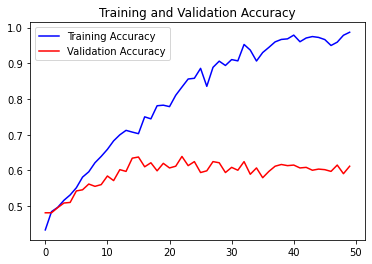

<Figure size 432x288 with 0 Axes>

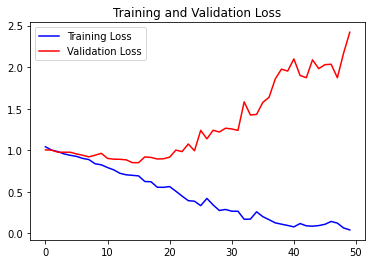

In [24]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [25]:
y_tst = y_test
y_test = np_utils.to_categorical(y_test, numclasses)
# Evaluate the accuracies
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

7/7 [==============================] - 6s 903ms/step - loss: 2.2263 - accuracy: 0.6405
Test score: 2.2263169288635254
Test accuracy: 0.6404638886451721


In [26]:
y_tst

array([1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0,
       1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1,
       0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0,
       1, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 0, 1, 1, 1, 1,
       2, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 1, 1, 1, 1, 2, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 2,
       2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 0, 1, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1,
       0, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 2, 2,

In [27]:
y_pred=model.predict(X_test)

In [28]:
y_pred

array([[9.4319148e-06, 9.9932277e-01, 6.6782645e-04],
       [6.2162857e-05, 9.9319297e-01, 6.7448709e-03],
       [1.8169191e-06, 9.9955589e-01, 4.4235430e-04],
       ...,
       [3.2169388e-05, 9.9970680e-01, 2.6093450e-04],
       [2.6107122e-05, 9.9914145e-01, 8.3240622e-04],
       [1.4064789e-05, 4.8101554e-04, 9.9950492e-01]], dtype=float32)

In [30]:
y_pred1=np.argmax(y_pred,axis=1)
y_pred1

array([1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2,
       2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1,
       2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2,
       1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 2,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 1,
       1, 0, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 1, 1, 2,
       2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 1, 1, 0, 2, 0, 2,
       1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1,
       1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1,

In [31]:
# y_pred = model.predict(X_test)
prediction = (y_pred > 0.5)
prediction

array([[False,  True, False],
       [False,  True, False],
       [False,  True, False],
       ...,
       [False,  True, False],
       [False,  True, False],
       [False, False,  True]])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.59      0.41      0.48       116
           1       0.69      0.73      0.71       395
           2       0.58      0.61      0.59       265

   micro avg       0.64      0.64      0.64       776
   macro avg       0.62      0.58      0.60       776
weighted avg       0.64      0.64      0.64       776
 samples avg       0.64      0.64      0.64       776



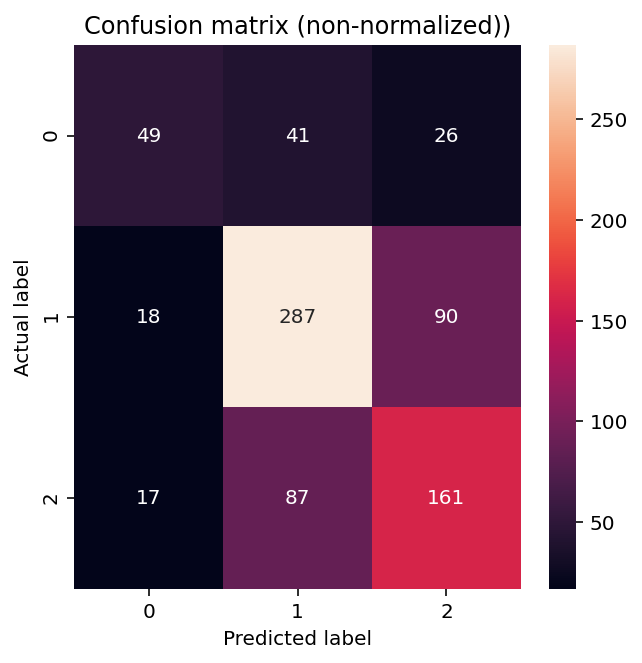

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, prediction)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_tst, y_pred1)